In [18]:
import ast
from textwrap import indent

from IPython.display import Javascript

from liblet import ANTLR, Tree

# Un linguaggio semplice

Iniziamo da un linguaggio semplice, con variabili di tipo intero, *scope* esclusivamente globale, e due sole strutture di controllo: la *selezione* e la *ripetizione* (ossia una iterazione controllata in cui il numero di itearti sia noto e fissato prima del suo inizio). Per chi sa cosa sono, questo linguaggio è in grado di esprimere tutte le funzioni *ricorsive primitive*, una conseguenza di questo fatto è che la computazione termina sempre.

Per consentire un embrione di I/O assumeremo che le variabili `INPUT<N>` (dove `<N>` è un intero) e `OUTPUT` siano già pre-dichiarate nell'ambiente d'esecuzione con l'ovvio significato: la prime conterranno l'*input* per il programma e, al termine dell'esecuzione, l'*interprete* emetterà il contenuto della seconda.

## Grammatica e parsing

In [19]:
SimpleLang = ANTLR(r"""grammar SimpleLang;

program: stat+ ;

expr: '!' expr #notExpr
    | expr '*' expr #prodExpr
    | expr ('+'|'-') expr #addSubExpr
    | expr '==' expr #equalityExpr
    | ID #varRefExpr
    | INT #intExpr
    | '(' expr ')' #subExpr
    ;

stat: 'var' ID ('=' expr)? ';' #varDeclStat
    | 'if' expr 'then' stat+ ('else' stat+)? 'fi' #ifElseStat
    | 'repeat' expr 'times' stat+ 'done' #repeatStat
    | ID '=' expr ';' #assignementStat
    ;

ID: LETTER (LETTER | [0-9])* ;
INT: [0-9]+ ;
WS: [ \t\n\r]+ -> skip ;
fragment
LETTER : [a-zA-Z] ;
""")

In [20]:
source = """
var somma = 0;
var n = 0;
repeat INPUT0 times
    n = n + 1;
    if n == 3 then
        OUTPUT = 100;
    fi
    if n == 4 then
        OUTPUT = 0;
    else
        OUTPUT = 10;
    fi
    somma = somma + n;
done
OUTPUT = OUTPUT + somma;
"""

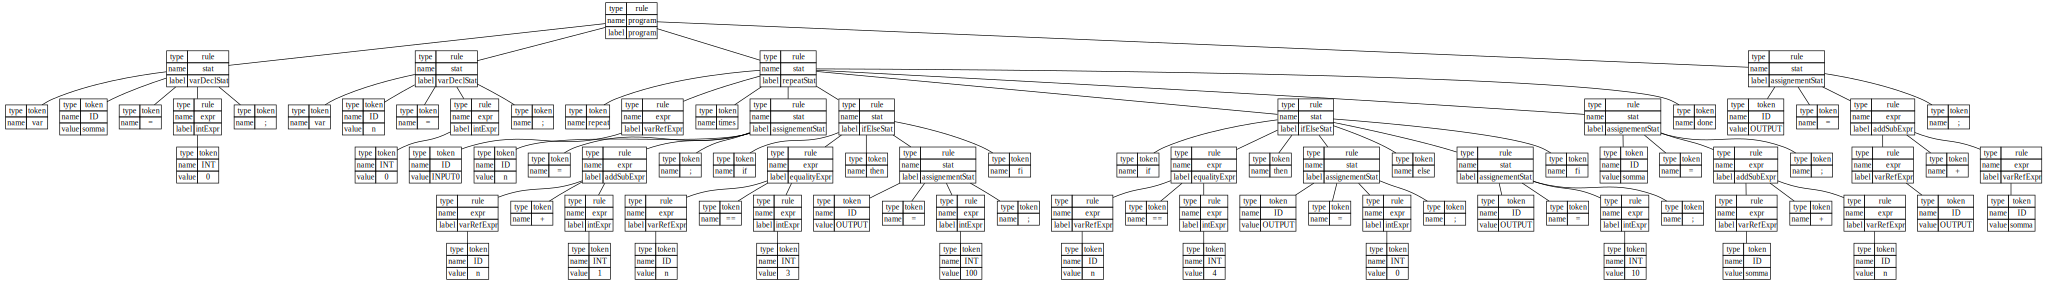

In [21]:
ptree = SimpleLang.tree(source, 'program')
ptree

## Dal parse tree all'AST

In [22]:
def register(dct):
    def _r(func):
        dct[func.__name__] = func
    return _r

In [55]:
ASTDT = {}

@register(ASTDT)
def intExpr(ptree):
    return Tree({'type': 'intExpr', 'value': int(ptree.children[0].root['value'])})

@register(ASTDT)
def addSubExpr(ptree):
    left, op, right = ptree.children
    return Tree({'type': 'binOpExpr', 'op': op.root['name']}, [simple2ast(left), simple2ast(right)])

@register(ASTDT)
def equalityExpr(ptree):
    left, _, right = ptree.children
    return Tree({'type': 'binOpExpr', 'op': '=='}, [simple2ast(left), simple2ast(right)])

@register(ASTDT)
def varRefExpr(ptree):
    return Tree({'type': 'varRefExpr', 'varName': ptree.children[0].root['value']})

@register(ASTDT)
def varDeclStat(ptree):
    name = ptree.children[1].root['value']
    if len(ptree.children) == 5:
        return Tree({'type': 'varDeclInitStat', 'varName': name}, [simple2ast(ptree.children[3])])
    else:
        return Tree({'type': 'varDeclStat', 'varName': name})

@register(ASTDT)
def assignementStat(ptree):
    name, _, right, _ = ptree.children
    return Tree({'type': 'assignementStat', 'varName': name.root['value']}, [simple2ast(right)])

@register(ASTDT)
def repeatStat(ptree):
    _, expr, _, *stats, _ = ptree.children
    return Tree({'type': 'repeatStat'}, [simple2ast(expr)] + [simple2ast(stat) for stat in stats])

@register(ASTDT)
def ifElseStat(ptree):
    _, cond, _, *stats, _ = ptree.children
    roots = [stat.root for stat in stats]
    if {'type': 'token', 'name': 'else'} in roots:
        elsePos = roots.index({'type': 'token', 'name': 'else'})
    else:
        elsePos = len(stats)
    return Tree({'type': 'ifElseStat', 'elsePos': elsePos}, 
                [simple2ast(cond)] +
                [simple2ast(stat) for stat in stats[:elsePos]] +
                [simple2ast(stat) for stat in stats[elsePos + 1:]]
            )

@register(ASTDT)
def program(ptree):
    return Tree({'type': 'program'}, [simple2ast(child) for child in ptree.children])

def simple2ast(ptree):
    key = ptree.root['label'] if ptree.root['type'] == 'rule' else ptree.root['name']
    if key in ASTDT: return ASTDT[key](ptree)
    return Tree({'type': '<UNDEF>', 'name': ptree.root['name']}, [simple2ast(child) for child in ptree.children])

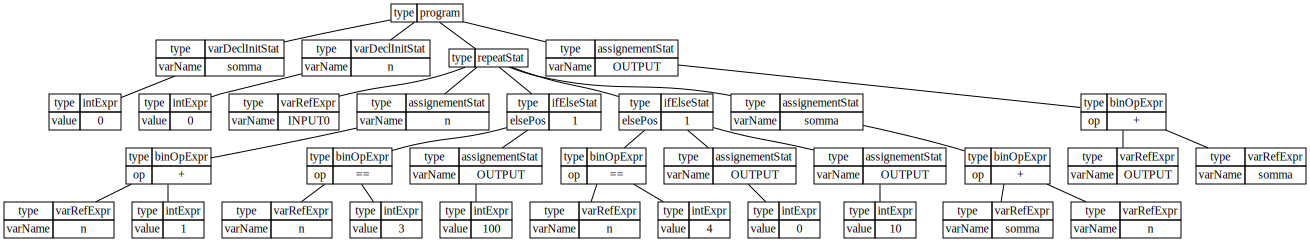

In [56]:
atree = simple2ast(ptree)
atree

# Transpilazione verso Javascript

In [10]:
JSDT = {}

@register(JSDT)
def intExpr(atree):
    return str(atree.root['value'])

@register(JSDT)
def binOpExpr(atree):
    return '{} {} {}'.format(simple2js(atree.children[0]), atree.root['op'], simple2js(atree.children[1]))

@register(JSDT)
def varRefExpr(atree):
    return atree.root['varName']

@register(JSDT)
def varDeclStat(atree):
    return 'let {};'.format(atree.root['varName'])

@register(JSDT)
def varDeclInitStat(atree):
    return 'let {} = {};'.format(atree.root['varName'], simple2js(atree.children[0]))

@register(JSDT)
def repeatStat(atree):
    count, *stats = atree.children
    stats = indent('\n'.join(simple2js(stat) for stat in stats), '\t')
    return 'for (let rv = 0; rv < {}; rv++) {{\n{}\n}}'.format(simple2js(atree.children[0]), stats) 

@register(JSDT)
def assignementStat(atree):
    return '{} = {};'.format(atree.root['varName'], simple2js(atree.children[0]))

@register(JSDT)
def program(atree):
    return '\n'.join(simple2js(child) for child in atree.children)

def simple2js(atree):
    key = atree.root['type']
    if key in JSDT: return JSDT[key](atree)
    return '\n'.join(simple2js(child) for child in atree.children)

In [20]:
code = simple2js(atree)
print(source)
print('-'*40)
print(code)


var somma = 0;
var n = 0;
repeat INPUT0 times
    n = n + 1;
    somma = somma + n;
done
OUTPUT = somma;

----------------------------------------
let OUTPUT = 0;
let INPUT0 = window.prompt("INPUT0");
let somma = 0;
let n = 0;
for (let rv = 0; rv < INPUT0; rv++) {
	n = n + 1;
	somma = somma + n;
}
OUTPUT = somma;
window.alert("OUTPUT " + OUTPUT)


## E l'input/output?

Facendo una analisi successiva al primo passo di transpilazione

In [12]:
SEEN_INPUT_VARS = set()

def geninput(atree):
    if atree.root['type'] == 'varRefExpr':
        name = atree.root['varName']
        if name.startswith('INPUT'): SEEN_INPUT_VARS.add(name)
    else:
        for child in atree.children: geninput(child)
        
geninput(atree)

INPUT_JS = '\n'.join('let {} = window.prompt("{}");'.format(name, name) for name in SEEN_INPUT_VARS)
print(INPUT_JS)

let INPUT0 = window.prompt("INPUT0");


In [13]:
code_withio = '\n'.join(['let OUTPUT = 0;', INPUT_JS, code, 'window.alert("OUTPUT " + OUTPUT)'])
print(code_withio)

let OUTPUT = 0;
let INPUT0 = window.prompt("INPUT0");
let somma = 0;
let n = 0;
for (let rv = 0; rv < INPUT0; rv++) {
	n = n + 1;
	somma = somma + n;
}
OUTPUT = somma;
window.alert("OUTPUT " + OUTPUT)


Oppure svolgendo l'analisi e l'aggiunta del codice durante la transpilazione

In [16]:
SEEN_INPUT_VARS = set()

@register(JSDT)
def varRefExpr(atree):
    name = atree.root['varName']
    if name.startswith('INPUT'): SEEN_INPUT_VARS.add(name)
    return name

@register(JSDT)
def program(atree):
    code = '\n'.join(simple2js(child) for child in atree.children)
    inputs = '\n'.join('let {} = window.prompt("{}");'.format(name, name) for name in SEEN_INPUT_VARS)
    return '\n'.join(['let OUTPUT = 0;', inputs, code, 'window.alert("OUTPUT " + OUTPUT)'])

code = simple2js(atree)
print(code)

let OUTPUT = 0;
let INPUT0 = window.prompt("INPUT0");
let somma = 0;
let n = 0;
for (let rv = 0; rv < INPUT0; rv++) {
	n = n + 1;
	somma = somma + n;
}
OUTPUT = somma;
window.alert("OUTPUT " + OUTPUT)


In [19]:
# Javascript(code_withio)

<IPython.core.display.Javascript object>

# Gli AST (nativi) di Python

## Dal sorgente all'AST e sua esplorazione

In [60]:
pysource = '1 + 3 * 4'

In [61]:
atree = ast.parse(pysource, mode = 'eval')
atree

In [62]:
# come stringa

ast.dump(atree)

'Expression(body=BinOp(left=Num(n=1), op=Add(), right=BinOp(left=Num(n=3), op=Mult(), right=Num(n=4))))'

In [72]:
pysource = """a == b"""
ast.dump(ast.parse(pysource, 'eval'))

"Module(body=[Expr(value=Compare(left=Name(id='a', ctx=Load()), ops=[Eq()], comparators=[Name(id='b', ctx=Load())]))])"

In [25]:
# visualizzato come Tree

def ast2tree(node):
    if not isinstance(node, ast.AST):
        return Tree({'type': 'token', 'value': node})
    else:
        return Tree({'type': 'ast', 'name': node.__class__.__name__}, 
            [ Tree(name, [ast2tree(v) for v in (value if isinstance(value, list) else [value])])
                for name, value in ast.iter_fields(node)
            ]     
        )                

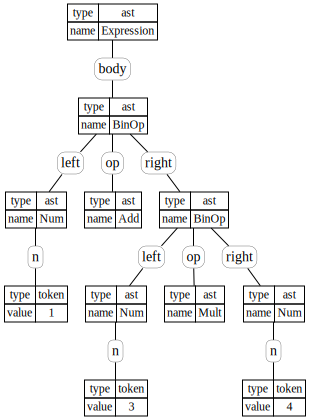

In [18]:
ast2tree(atree)

## Compilazione ed esecuzione dell'AST

In [19]:
code  = compile(atree, filename = '<ast>', mode = 'eval')
pysource, eval(code)

('1 + 3 * 4', 13)

## Costruzione "manuale" di un AST

Per una descrizione dei nodi si veda:

* l'[Abstract Grammar](https://docs.python.org/3/library/ast.html#abstract-grammar) riportata nella documentazione ufficiale e
* la sezione [Meet the Nodes](https://greentreesnakes.readthedocs.io/en/latest/nodes.html) della documentazione "Green Tree Snakes".

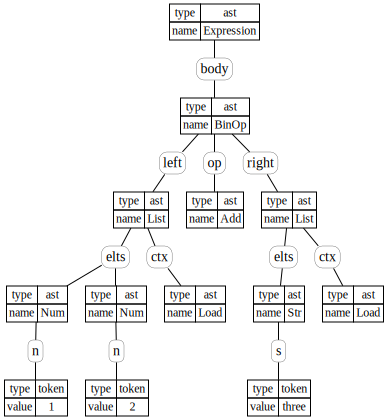

In [20]:
atree = ast.Expression(
    body = ast.BinOp(
        left = ast.List([ast.Num(1), ast.Num(2)], ctx = ast.Load()),
        op = ast.Add(),
        right = ast.List([ast.Str('three')], ctx = ast.Load())
    )
    
)

ast2tree(atree)

In [21]:
# prima di eseguire vanno aggiunti i numeri di linea e colonna

ast.fix_missing_locations(atree)

code  = compile(atree, filename = '<ast>', mode = 'eval')
eval(code)

[1, 2, 'three']

# Transpilazione verso gli AST (naativi) di Python

In [73]:
PYDT = {}

@register(PYDT)
def intExpr(atree):
    return ast.Num(n = atree.root['value'])

@register(PYDT)
def binOpExpr(atree):
    left = simple2py(atree.children[0])
    right = simple2py(atree.children[1])
    if atree.root['op'] == '+':
        return ast.BinOp(left = left, op = ast.Add(), right = right)
    elif atree.root['op'] == '-':
        return ast.BinOp(left = left, op = ast.Add(), right = right)
    elif atree.root['op'] == '==':
        return ast.Compare(left = left, ops=[ast.Eq()], comparators = [right])

@register(PYDT)
def varRefExpr(atree):
    return ast.Name(id = atree.root['varName'], ctx = ast.Load())

@register(PYDT)
def varDeclStat(atree):
    return ast.Assign(targets = [ast.Name(id = atree.root['varName'], ctx = ast.Store())], value = ast.Num(n = 0))

@register(PYDT)
def varDeclInitStat(atree):
    return ast.Assign(targets = [ast.Name(id = atree.root['varName'], ctx = ast.Store())], value = simple2py(atree.children[0]))

@register(PYDT)
def repeatStat(atree):
    count, *stats = atree.children
    return ast.For(
        target = ast.Name(id = 'rv', ctx = ast.Store()), 
        iter = ast.Call( 
                    func = ast.Name(id = 'range', ctx = ast.Load()), 
                    args = [simple2py(count)], 
                    keywords = []
                ), 
        body = [simple2py(stat) for stat in stats], 
        orelse = []
    )

@register(PYDT)
def ifElseStat(atree):
    elsePos = atree.root['elsePos']
    stats = atree.children[1:]
    return ast.If(
        test = simple2py(atree.children[0]), 
        body = [simple2py(stat) for stat in stats[:elsePos]], 
        orelse = [simple2py(stat) for stat in stats[elsePos:]], 
    )

@register(PYDT)
def assignementStat(atree):
    return ast.Assign(targets = [ast.Name(id = atree.root['varName'], ctx = ast.Store())], value = simple2py(atree.children[0]))

@register(PYDT)
def program(atree):
    return ast.Module(body = [simple2py(child) for child in atree.children])

def simple2py(atree):
    key = atree.root['type']
    if key in PYDT: return PYDT[key](atree)
    return [simple2py(child) for child in atree.children]

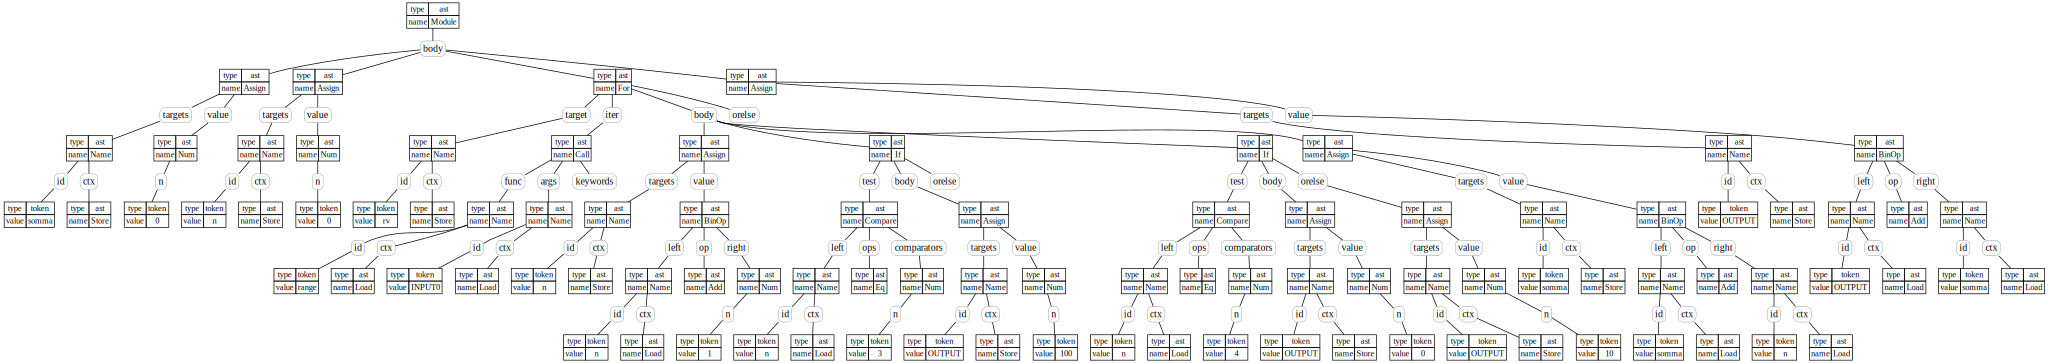

In [74]:
pyast = simple2py(simple2ast(SimpleLang.tree(source, 'program')))
ast2tree(pyast)

### E l'I/O?

In questo caso possiamo usare l'ambiete di esecuzione dell'interprete stesso

In [75]:
ast.fix_missing_locations(pyast)

code  = compile(pyast, filename = '<ast>', mode = 'exec')

localvars = {'INPUT0': 10}
exec(code, globals(), localvars)
localvars['OUTPUT']

65

In [16]:
a = [1,2,3,{'a' :'X'},4,5,6,7]
a.index({'a': 'X'})

3

In [13]:
[i for i in a if i == 'X' break]

SyntaxError: invalid syntax (<ipython-input-13-d0a34542d485>, line 1)